In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import pyaudio
import pylab
import scipy as sp
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio
pylab.rcParams['figure.figsize'] = (16, 4)

## Utilities

In [2]:
def record(sec, rate, channels=1):
    ex_chunk = 1024
    ex_format = pyaudio.paInt32
    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=channels, rate=rate, input=True, frames_per_buffer=ex_chunk)
    buf = []
    for i in range(0, int(rate / ex_chunk * sec)):
        data = stream.read(ex_chunk)
        buf.append(np.fromstring(data, 'Int32'))
    stream.stop_stream()
    stream.close()
    p.terminate()
    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / channels, channels])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / channels
    return ex

In [3]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [4]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

In [5]:
def waveform_encoder(pattern, pulse_1, pulse_2):
    pulse_1 = np.array(pulse_1);
    pulse_2 = np.array(pulse_2);
    return np.array([pulse_1 if c == 0 else pulse_2 for c in pattern]).flatten()

In [6]:
def match_decoder(signal, pulse_1, pulse_2, sample_dt, flip, plot=False):
    match_1 = (fast_corr(signal, pulse_1))
    match_2 = (fast_corr(signal, pulse_2))
    if plot:
        plt.plot(match_1)
        plt.show()
        plt.plot(match_2)
        plt.show()
    samples_1 = match_1[np.arange(0, len(match_1), int(sample_dt))]
    samples_2 = match_2[np.arange(0, len(match_2), int(sample_dt))]
    for x,y in zip(samples_1, samples_2):
        print(str(x/len(samples_1)/rate) + " " + str(y/rate/len(samples_1)))
        
    if not flip:
        return [1 if x < 0 else 0 for x, y in zip(samples_1, samples_2)]
    else :
        return [1 if x > 0 else 0 for x, y in zip(samples_1, samples_2)]


In [7]:
def fast_corr(data, pattern, verify=False):
    data_len = len(data)
    data_half_len = data_len // 2
    data_even = np.zeros(data_len * 2)
    data_even[data_half_len:data_half_len + data_len] = data
    corr = sp.signal.fftconvolve(data_even, pattern[::-1], mode='valid')
    ret = corr[data_half_len:data_half_len + data_len - len(signal_delim) + 1]
    if verify:
        assert np.allclose(ret, np.correlate(data, pattern))
    return ret

In [8]:
def lcs(t1, t2):
    s1 = "".join([str(c) for c in t1])
    s2 = "".join([str(c) for c in t2])
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

## Configuration

In [9]:
rate = 44100 
origin_dt = 1
pulse_dt = 0.01
pulse_replicate = 0
pulse_df = 1
delim_dt = 10
analysis_dt = 10
freq_min = 50
freq_max = 8000 # or rate // 4
redundency = 1 # must be odd

## Channel analysis

In [10]:
#channel = record(analysis_dt, rate)
#Audio(channel, rate=rate)

In [11]:
channel_rate1, channel1 = sp.io.wavfile.read("interference.wav")
channel_rate2, channel2 = sp.io.wavfile.read("interference2.wav")
channel_rate3, channel3 = sp.io.wavfile.read("interference3.wav")
channel1 = channel1[:channel_rate1 * analysis_dt]
channel2 = channel2[:channel_rate2 * analysis_dt]
channel3 = channel3[:channel_rate3 * analysis_dt]
channel1 = sp.signal.resample(channel1, rate * analysis_dt)
channel2 = sp.signal.resample(channel2, rate * analysis_dt)
channel3 = sp.signal.resample(channel3, rate * analysis_dt)

In [12]:
channel = channel1
Audio(channel, rate=rate)

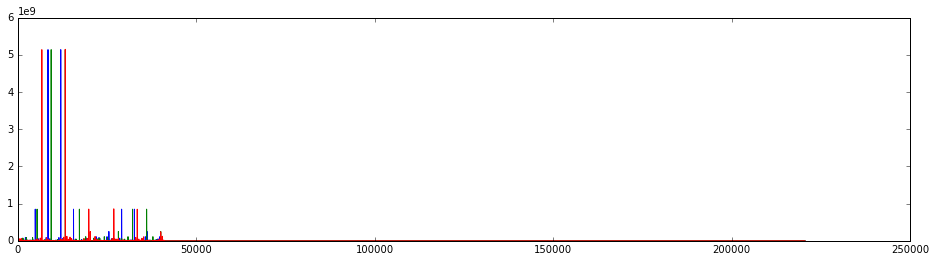

In [13]:
plt.plot(np.abs(np.fft.rfft(channel1)))
plt.plot(np.abs(np.fft.rfft(channel2)))
plt.plot(np.abs(np.fft.rfft(channel3)))

In [14]:
[noise_freq_1, noise_freq_2] = np.argsort(- np.fft.rfft(channel))[:2] / analysis_dt
[noise_freq_1, noise_freq_2]

[852.0, 1209.0]

In [15]:
t = np.linspace(0, analysis_dt, rate * analysis_dt)
channel_sim = np.cos(2 * np.pi * noise_freq_1 * t) + np.cos(2 * np.pi * noise_freq_2 * t)
Audio(channel_sim, rate=rate)

/home/nicolas/Applications/Anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


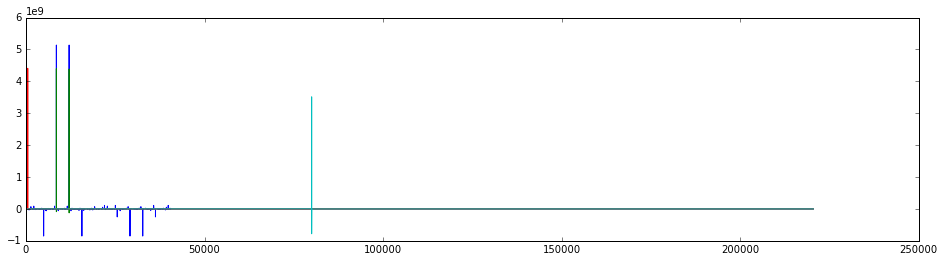

In [16]:
plt.plot(np.fft.rfft(channel))
plt.plot(2e4 * np.fft.rfft(channel_sim))
plt.plot(2e4 * np.fft.rfft(np.cos(2 * np.pi * freq_min * t)))
plt.plot(2e4 * np.fft.rfft(np.cos(2 * np.pi * freq_max * t)))

In [17]:
Audio(np.cos(2 * np.pi * freq_min * t), rate=rate)

In [18]:
Audio(np.cos(2 * np.pi * freq_max * t), rate=rate)

In [19]:
channel_specs = np.sort([freq_min, noise_freq_1, noise_freq_2, freq_max])
channel_ranges = list(zip(channel_specs, channel_specs[1:]))
[range_start, range_end] = max(channel_ranges,key=lambda range:range[1] - range[0])
[range_start, range_end]

[1209.0, 8000.0]

In [20]:
[pulse_freq_1, pulse_freq_d, pulse_freq_2] = np.linspace(range_start, range_end, 3 + 2)[1:-1]
[pulse_freq_1, pulse_freq_d, pulse_freq_2]

[2906.75, 4604.5, 6302.25]

## Pulse design

In [21]:
def design_pulse(sign, freq, pulse_dt, rate, pulse_replicate, pulse_df):
    beta = 0.5
    pulse_t = np.linspace(-pulse_dt * 4 / 2, pulse_dt * 4 /2, rate * pulse_dt)
    
    fp = 4 * beta / (np.pi * np.sqrt(pulse_dt))
    nominF = np.cos((1+beta)* np.pi * pulse_t / pulse_dt) 
    nominS1 = np.sinc((1-beta) * pulse_t / pulse_dt)
    nominS2 = (1-beta) * np.pi / (4 *beta)
    denomin = 1 - np.power(4 * beta * pulse_t / pulse_dt, 2)
    
    out = []
    for value, index in zip(denomin, range(0, len(denomin))):
        if(value == 0):
            out.append(np.cos(2*np.pi * -500 * pulse_t[index])*sign*((np.pi + 2) * np.sin(np.pi / (4 * beta)) + (np.pi - 2)*np.cos(np.pi / (4*beta)))*beta / (np.pi *np.sqrt(2*pulse_dt)))
        else:
            out.append(np.cos(2*np.pi * -500 * pulse_t[index])*sign*fp*(nominF[index] + nominS1[index]*nominS2) /denomin[index])
    return out

In [22]:
pulse_1 = design_pulse(1, pulse_freq_1, pulse_dt, rate, pulse_replicate, pulse_df)
Audio(pulse_1, rate=rate)

In [23]:
pulse_2 = design_pulse(-1, pulse_freq_2, pulse_dt, rate, pulse_replicate, pulse_df)
Audio(pulse_2, rate=rate)

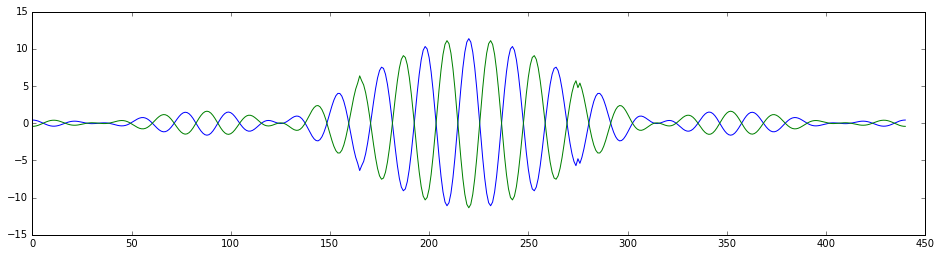

In [24]:
plt.plot(pulse_1[:])
plt.plot(pulse_2[:])

## Emitter

In [25]:
pulse_t = np.linspace(0, pulse_dt, rate * pulse_dt)
delim = np.sin(2 * np.pi * 300 * pulse_t / pulse_dt)
Audio(delim, rate=rate)

In [26]:
textfile = open('textfile.txt', 'r')
message = textfile.read()[:27]
textfile.close()
message = "Top kek patate j'aime pas OS."

In [27]:
message_bin = binarize(message)
assert message == textarize(message_bin)
len(message_bin)

message_bin_redundent = []
for i in message_bin:
    for j in range(0, redundency):
        message_bin_redundent.append(i)


<Container object of 3 artists>

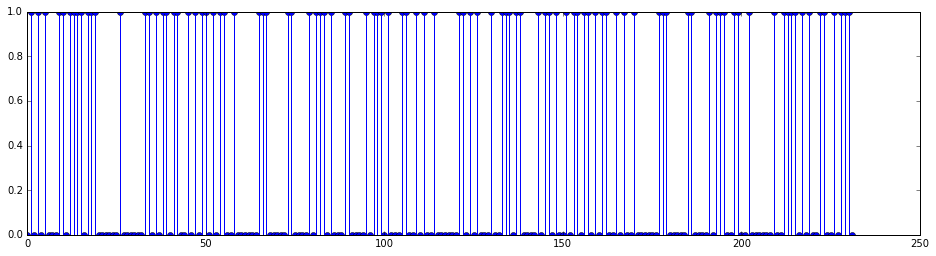

In [28]:
plt.stem(message_bin_redundent)

In [29]:
signal_delay = np.zeros(origin_dt * rate)
signal_delim = delim*10
signal_data = waveform_encoder(message_bin_redundent, pulse_1, pulse_2)
signal = np.concatenate((signal_delay, signal_delim, signal_data, signal_delim, signal_delay))
#sp.io.wavfile.write("trans.wav", rate, signal)
Audio(signal, rate=rate)

In [30]:
signal_t = len(signal) / rate
signal_t

4.34

In [43]:
recorded = signal

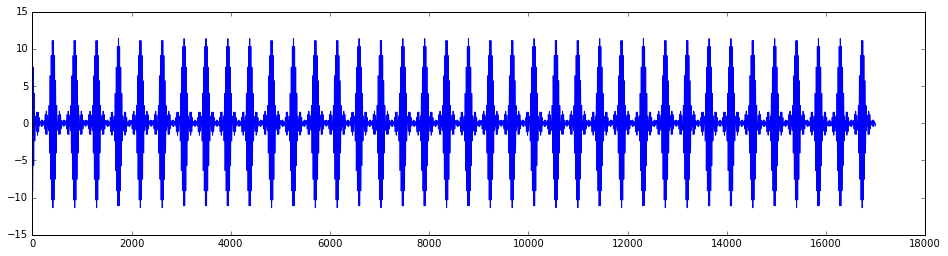

In [32]:
plt.plot(signal[103000:120000])

## Receiver

In [58]:
recorded = record(6, rate)

In [34]:
Audio(recorded, rate=rate)

In [59]:
xcorr = fast_corr(recorded, signal_delim)

In [60]:
mid = len(xcorr) // 2
corr_end = len(xcorr) - np.argmax(xcorr[mid:][::-1])
corr_start = corr_end - len(signal_data) - len(signal_delim) - 1
[corr_start, corr_end]

[69137, 171891]

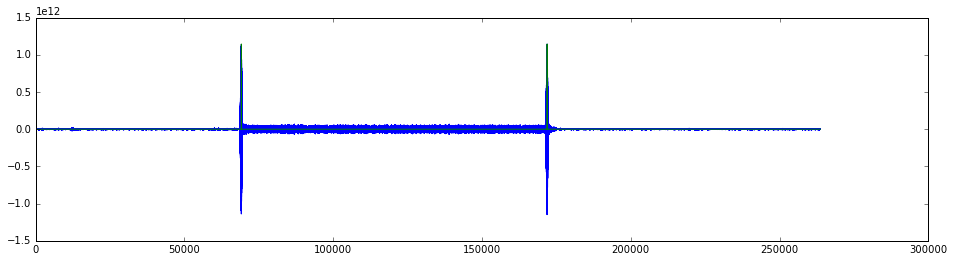

In [61]:
plt.plot(xcorr)
corr_bounds = np.zeros(len(xcorr))
corr_bounds[corr_start] = np.max(xcorr)
corr_bounds[corr_end] = np.max(xcorr)
plt.plot(corr_bounds)

In [62]:
received_window = recorded[corr_start:corr_end]
received_align = match_decoder(received_window, pulse_1, pulse_2, rate * pulse_dt, False, plot=False)
received = received_align[1:]

1030.7405142 -1030.7405142
152574.640944 -152574.640944
-154662.95874 154662.95874
153547.228782 -153547.228782
-152887.676609 152887.676609
151853.248808 -151853.248808
-152684.074551 152684.074551
153327.257542 -153327.257542
154342.829786 -154342.829786
150523.053992 -150523.053992
-154181.506246 154181.506246
-152685.798847 152685.798847
157814.360491 -157814.360491
-152516.923174 152516.923174
-156300.711779 156300.711779
-153432.424526 153432.424526
-152552.725627 152552.725627
157211.124087 -157211.124087
-156119.00371 156119.00371
-157244.031965 157244.031965
-152824.239408 152824.239408
155983.442913 -155983.442913
154537.182084 -154537.182084
150209.658401 -150209.658401
151218.050618 -151218.050618
153232.654937 -153232.654937
153575.9896 -153575.9896
-154605.434215 154605.434215
154158.167067 -154158.167067
156030.487338 -156030.487338
152605.209627 -152605.209627
154018.033761 -154018.033761
153852.615675 -153852.615675
155847.281589 -155847.281589
-152965.106832 152965.10

<Container object of 3 artists>

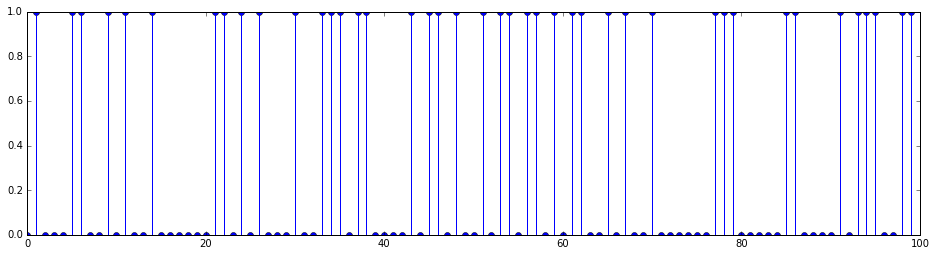

In [63]:
plt.stem(received[100:200])

In [64]:
remove_redundency = []
for i in range(0, len(received) // redundency):
    tmp = []
    for j in range (0, redundency):
        tmp.append(received[i*redundency: i * redundency + redundency])
    median = np.median(tmp)
    assert int(median) == median
    remove_redundency.append(int(median))
received = remove_redundency

In [65]:
for i in range(0,8):
    print(str(i) + ':  ' + textarize(received[i:]))
          
len(received)

0:  Top kek patate j'aime pas OS.
1:  ¨Þà@ÖÊÖ@àÂèÂèÊ@ÔNÂÒÚÊ@àÂæ@¦.
2:  Q½À­¬ÁÑÑ¨¥µÁÌ=L.
3:  £{[+Y££)Q;Kk)z
4:  F÷¶V²FFR¢vÖR2õ2
Dì--¬¤.d	êe
6:  ÜÙZÈ]]HØZ[YH\ÈÔË
7:  7¸5²µ80º0º25°´¶²80¹'© 


232

In [66]:
print(len(lcs(received, message_bin)))
for x, y in zip(message_bin, received):
    print(str(x) + " " + str(y))


232
0 0
1 1
0 0
1 1
0 0
1 1
0 0
0 0
0 0
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
0 0
0 0
0 0
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 0
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
0 0
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
